In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import numpy as np 
import pandas as pd
import os
import shutil
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import Xception

In [3]:
df = pd.read_csv('data_llhajbb.csv',sep=',' )

AUTO = tf.data.experimental.AUTOTUNE

In [4]:
df.head()

,path_image,lebel
0,new_data0.jpeg,rouille
1,new_data1.jpeg,rouille
2,new_data2.jpeg,rouille
3,new_data3.jpeg,rouille
4,new_data4.jpeg,rouille


In [5]:
a=df.copy()
a=pd.get_dummies(a['lebel'])
df1=pd.concat([df, a], axis=1)
df1.head()

,path_image,lebel,acariens,chancre fusicocum,coryneum,faux tigre,othyorinques,polystigma,puceron noir,puceron vert,rouille,scolytes
0,new_data0.jpeg,rouille,0,0,0,0,0,0,0,0,1,0
1,new_data1.jpeg,rouille,0,0,0,0,0,0,0,0,1,0
2,new_data2.jpeg,rouille,0,0,0,0,0,0,0,0,1,0
3,new_data3.jpeg,rouille,0,0,0,0,0,0,0,0,1,0
4,new_data4.jpeg,rouille,0,0,0,0,0,0,0,0,1,0


In [6]:
data=df1[df1['puceron noir']!=1]

In [7]:
data=data[data['scolytes']!=1]
data=data[data['puceron vert']!=1]

In [8]:
data.drop(columns='lebel', inplace=True)

data.shape

(402, 11)

In [9]:
data.drop(columns=['puceron noir','scolytes','puceron vert'],inplace=True)

In [10]:
data.head()

,path_image,acariens,chancre fusicocum,coryneum,faux tigre,othyorinques,polystigma,rouille
0,new_data0.jpeg,0,0,0,0,0,0,1
1,new_data1.jpeg,0,0,0,0,0,0,1
2,new_data2.jpeg,0,0,0,0,0,0,1
3,new_data3.jpeg,0,0,0,0,0,0,1
4,new_data4.jpeg,0,0,0,0,0,0,1


In [11]:
data.columns

Index(['path_image', 'acariens', 'chancre fusicocum', 'coryneum', 'faux tigre',
       'othyorinques', 'polystigma', 'rouille'],
      dtype='object')

<ipython-input-12-e50005ee8130>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pcts=data.mean()


<AxesSubplot:ylabel='None'>

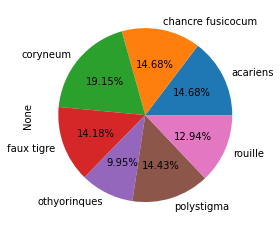

In [12]:
pcts=data.mean()
pcts.plot(kind = 'pie',autopct='%1.2f%%')

In [13]:
img_size={'height': 960,
         'width': 1280 }

In [14]:
data.shape

(402, 8)

In [15]:
path='paths/'
data_path=data.path_image.apply(lambda x: path +x).values

(1280, 958, 3)


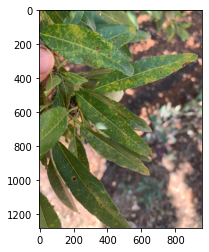

In [16]:
from matplotlib import pyplot as plt

img = plt.imread(path+'new_data1.jpeg')
print(img.shape)
plt.imshow(img)

In [17]:
data_path

array(['paths/new_data0.jpeg', 'paths/new_data1.jpeg',
       'paths/new_data2.jpeg', 'paths/new_data3.jpeg',
       'paths/new_data4.jpeg', 'paths/new_data5.jpeg',
       'paths/new_data6.jpeg', 'paths/new_data7.jpeg',
       'paths/new_data8.jpeg', 'paths/new_data9.jpeg',
       'paths/new_data10.jpeg', 'paths/new_data11.jpeg',
       'paths/new_data12.jpeg', 'paths/new_data13.jpeg',
       'paths/new_data14.jpeg', 'paths/new_data15.jpeg',
       'paths/new_data16.jpeg', 'paths/new_data17.jpeg',
       'paths/new_data18.jpeg', 'paths/new_data19.jpeg',
       'paths/new_data20.jpeg', 'paths/new_data21.jpeg',
       'paths/new_data22.jpeg', 'paths/new_data23.jpeg',
       'paths/new_data24.jpeg', 'paths/new_data25.jpeg',
       'paths/new_data26.jpeg', 'paths/new_data27.jpeg',
       'paths/new_data28.jpeg', 'paths/new_data29.jpeg',
       'paths/new_data30.jpeg', 'paths/new_data31.jpeg',
       'paths/new_data32.jpeg', 'paths/new_data33.jpeg',
       'paths/new_data34.jpeg', 'paths/ne

In [18]:
data_labels = data.loc[:, ['acariens', 'chancre fusicocum', 'faux tigre','othyorinques', 'polystigma','coryneum', 'rouille']].values

In [19]:
train_paths, test_paths, train_labels, test_labels =train_test_split(data_path, data_labels, test_size=0.2, random_state=42)


In [20]:
len(test_paths)

81

In [46]:
IMG_SIZE=299
def decode_image(filename, label=None, IMG_SIZE=(IMG_SIZE, IMG_SIZE)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, IMG_SIZE)
    
    if label is None:
        return image
    else:
        return image, label


def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

In [73]:
BATCH_SIZE = 8

train_dataset = (
tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_paths,test_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    
)

In [74]:
LR_START = 0.00001
LR_MAX = 0.00005 
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [75]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow import keras

Dense_net = keras.models.load_model('xceptions')

In [76]:
Dense_net.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [77]:
x = Dense_net.get_layer("global_average_pooling2d_3").output

#x = tf.keras.layers.Dense(1024, activation='softmax')(x)
x = tf.keras.layers.Dense(7, activation='softmax')(x)
model = keras.Model(inputs = Dense_net.input,outputs=x)
model.compile( optimizer= 'adam',loss="categorical_crossentropy", metrics=["accuracy"])

In [78]:
history=model.fit(
    train_dataset,
    steps_per_epoch=data_labels.shape[0] // BATCH_SIZE,
    epochs=80,
    validation_data=test_dataset
    )

Epoch 1/80
50/50 [==============================] - 30s 389ms/step - loss: 1.7871 - accuracy: 0.3100 - val_loss: 1.8338 - val_accuracy: 0.3086
Epoch 2/80
50/50 [==============================] - 19s 376ms/step - loss: 1.3790 - accuracy: 0.4150 - val_loss: 1.9132 - val_accuracy: 0.3333
Epoch 3/80
50/50 [==============================] - 19s 381ms/step - loss: 1.1427 - accuracy: 0.6050 - val_loss: 2.8326 - val_accuracy: 0.3951
Epoch 4/80
50/50 [==============================] - 19s 387ms/step - loss: 0.9163 - accuracy: 0.6550 - val_loss: 3.6423 - val_accuracy: 0.2593
Epoch 5/80
50/50 [==============================] - 19s 384ms/step - loss: 0.8250 - accuracy: 0.6975 - val_loss: 1.1519 - val_accuracy: 0.5556
Epoch 6/80
50/50 [==============================] - 19s 383ms/step - loss: 0.7040 - accuracy: 0.7675 - val_loss: 2.3339 - val_accuracy: 0.5062
Epoch 7/80
50/50 [==============================] - 19s 385ms/step - loss: 0.6799 - accuracy: 0.7550 - val_loss: 1.0860 - val_accuracy: 0.5802

Epoch 58/80
50/50 [==============================] - 19s 381ms/step - loss: 0.1483 - accuracy: 0.9675 - val_loss: 1.5203 - val_accuracy: 0.6914
Epoch 59/80
50/50 [==============================] - 19s 383ms/step - loss: 0.0914 - accuracy: 0.9700 - val_loss: 1.9005 - val_accuracy: 0.6543
Epoch 60/80
50/50 [==============================] - 19s 382ms/step - loss: 0.1315 - accuracy: 0.9700 - val_loss: 0.9060 - val_accuracy: 0.7778
Epoch 61/80
50/50 [==============================] - 19s 385ms/step - loss: 0.0398 - accuracy: 0.9850 - val_loss: 1.0173 - val_accuracy: 0.8148
Epoch 62/80
50/50 [==============================] - 19s 384ms/step - loss: 0.0662 - accuracy: 0.9825 - val_loss: 1.0031 - val_accuracy: 0.7901
Epoch 63/80
50/50 [==============================] - 19s 382ms/step - loss: 0.0870 - accuracy: 0.9750 - val_loss: 1.9956 - val_accuracy: 0.6667
Epoch 64/80
50/50 [==============================] - 19s 384ms/step - loss: 0.0589 - accuracy: 0.9800 - val_loss: 2.3578 - val_accuracy:

In [79]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        #plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

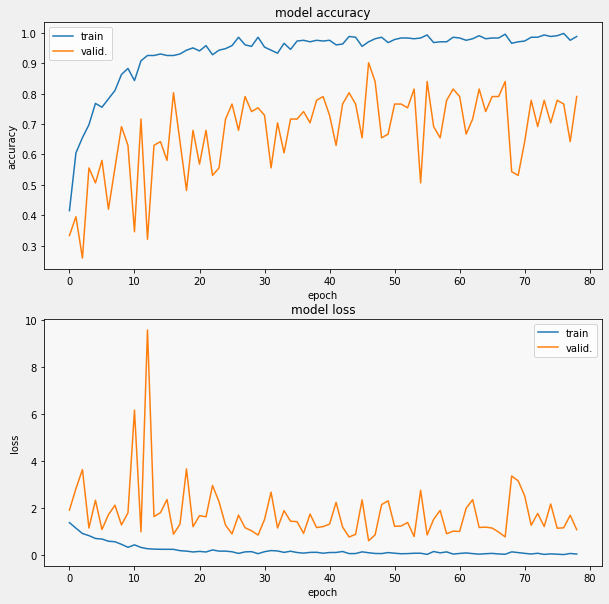

In [80]:
display_training_curves(history.history['accuracy'][1:], history.history['val_accuracy'][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

In [81]:
import pickle
with open('training_log/xception_newdata408_300px_v2.pkl', 'wb') as output:
        pickle.dump(history.history, output)